<a href="https://colab.research.google.com/github/boredanon/machine-learning2023-2/blob/main/proyecto_ML_Jos%C3%A9_del_Solar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enunciado

Se presenta un conjunto de datos cuyo origen se mantiene confidencial. Este conjunto consta de 481 columnas de números reales distribuidos en 93 instancias, siendo la columna designada como ''Y'' la variable objetivo a predecir.

El propósito de esta investigación es identificar y evaluar un conjunto de modelos de regresión con el fin de lograr predicciones más precisas para los datos seleccionados.

## 1. Obteniendo los datos


Vamos a obtener los datos directamente desde Google Spreadsheets, para esto se necesita instalar el paquete gspread de Python.

Solo corra este bloque si se encuentra en una máquina que no tenga instalada gspread, como una terminal en Google Colab.

In [1]:
!pip install --upgrade -q gspread

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 902.0 kB/s eta 0:00:00


Con la ayuda de gspread, se puede obtener la información directamente vinculando la hoja de cálculo proporcionada en el enunciado. Para su funcionamiento, a pesar de que los datos se encuentran públicos, se requiere que la persona acceda a su cuenta de Google Drive, sin embargo, no se accederá a ninguno de sus datos, solo es para poder abrir la hoja de cálculo. 👀

In [2]:
import gspread
import pandas as pd
from google.colab import auth
from google.auth import default

# Log in to Google Drive.
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

sh = gc.open_by_url("https://docs.google.com/spreadsheets/d/1cJZIUTPoYliSej8ZQumPdrvWjcZeRyuEqyC4JyXpx-8/edit#gid=1570725307")
worksheet_A = sh.worksheet("A")
worksheet_B = sh.worksheet("B") #There are two worksheets.

rows_B = worksheet_B.get_all_values()[1:]
rows = worksheet_A.get_all_values() + rows_B
df = pd.DataFrame(rows[1:], columns = rows[0])


X = df.drop(columns=['Y'])
y = df['Y']

#Cast it to float, gspread apparently loads the data as type "object"
X = X.astype(float)
y = y.astype(float)


Veamos si cargó correctamente:


1.   93 instancias
2.   480 columnas en X, 1 columna en y.



In [3]:
X.info()
print("\n")
y.info()

X.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Columns: 480 entries, X1 to X480
dtypes: float64(480)
memory usage: 348.9 KB


<class 'pandas.core.series.Series'>
RangeIndex: 93 entries, 0 to 92
Series name: Y
Non-Null Count  Dtype  
--------------  -----  
93 non-null     float64
dtypes: float64(1)
memory usage: 872.0 bytes


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X471,X472,X473,X474,X475,X476,X477,X478,X479,X480
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,...,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,921.198065,922.966667,921.956774,921.920108,924.829462,923.234946,921.457419,921.599140,922.459892,922.065376,...,3.259355,3.415376,3.300323,3.445161,3.396129,3.283548,3.470753,3.470430,3.415484,3.407634
std,21.580701,23.203403,23.120603,22.511511,21.168588,22.694371,22.962681,22.545082,22.642812,19.751497,...,0.400949,0.464228,0.719723,0.424017,0.516049,0.544076,0.278045,0.688213,0.421953,0.685205
min,898.170000,898.200000,897.320000,897.560000,901.710000,898.870000,896.620000,897.200000,898.160000,900.230000,...,2.780000,2.790000,2.580000,2.940000,2.830000,2.710000,3.110000,2.690000,2.890000,2.670000
25%,901.530000,901.860000,900.910000,901.410000,905.570000,902.510000,900.560000,901.040000,901.840000,904.050000,...,2.900000,3.000000,2.650000,3.060000,2.930000,2.790000,3.230000,2.850000,3.040000,2.780000
50%,904.250000,904.510000,903.540000,904.280000,908.230000,905.360000,903.320000,904.020000,904.790000,907.040000,...,2.930000,3.070000,2.710000,3.130000,2.990000,2.840000,3.280000,2.920000,3.070000,2.850000
75%,943.910000,947.530000,946.310000,945.570000,947.030000,947.190000,945.530000,945.260000,946.130000,942.730000,...,3.700000,3.920000,4.080000,3.900000,3.970000,3.870000,3.780000,4.210000,3.880000,4.160000
max,948.090000,951.620000,950.710000,949.700000,951.060000,951.500000,950.090000,949.820000,950.590000,947.050000,...,3.770000,4.000000,4.160000,3.970000,4.020000,3.940000,3.840000,4.320000,3.940000,4.240000


In [4]:
y.describe()

count    93.000000
mean     -1.341935
std       1.841017
min      -6.700000
25%      -2.500000
50%      -0.960000
75%       0.000000
max       1.800000
Name: Y, dtype: float64

Se puede observar que dentro del dataframe X distintas columnas tienen distintas escalas de magnitud, pero eso es parte del procesamiento de los datos. Por lo menos se puede verificar que cargaron correctamente hasta este punto.

## 2. Procesamiento y manipulación de los datos

Primero, se revisará si existen datos faltantes dentro de las 481 columnas.

In [5]:
print(df.isnull().sum())

Y       0
X1      0
X2      0
X3      0
X4      0
       ..
X476    0
X477    0
X478    0
X479    0
X480    0
Length: 481, dtype: int64


Se puede observar que no hay datos faltantes dentro de las columnas, por lo que no se necesita hacer nada extra relacionado con eso.

Luego, podemos separar los datos en set de entrenamiento y set de test. Se usa la proporción 80/20, que es estándar en proyectos de Machine Learning.

Se estandarizan los datos usand el "Z-score" de cada columna, también conocida como "unidad tipificada" o "unidad estándar". El Z-score es simplemente la cantidad de desviaciones estándar que un individuo se encuentra de la media de la población.

El Z-score de un individuo se calcula de la siguiente forma
$z = \frac{x - \mu}{σ}$, donde $x$ es el valor del individuo, $\mu$ es la media de la población y $\sigma$ es la desviación estándar.

En este caso, el Z-score se calcula independientemente para cada columna. Es decir, para los elementos de la columna $X_i$ se calcula respecto a la población de la misma columna $X_i$.

In [6]:
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_zscore_train = zscore(X_train, axis=0)

X_zscore_train.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X471,X472,X473,X474,X475,X476,X477,X478,X479,X480
count,7.400000e+01,7.400000e+01,7.400000e+01,7.400000e+01,7.400000e+01,7.400000e+01,7.400000e+01,7.400000e+01,7.400000e+01,7.400000e+01,...,7.400000e+01,7.400000e+01,7.400000e+01,7.400000e+01,7.400000e+01,7.400000e+01,7.400000e+01,7.400000e+01,7.400000e+01,7.400000e+01
mean,-3.260155e-15,1.542310e-15,3.053113e-15,-1.168735e-15,1.150731e-15,-3.245152e-15,8.907289e-15,5.752156e-15,-6.899886e-15,1.489349e-14,...,1.237749e-15,-6.841374e-16,4.875980e-16,-1.050211e-16,5.551115e-16,-1.770356e-16,7.021410e-16,-7.066420e-16,4.710946e-16,-4.200844e-16
std,1.006826e+00,1.006826e+00,1.006826e+00,1.006826e+00,1.006826e+00,1.006826e+00,1.006826e+00,1.006826e+00,1.006826e+00,1.006826e+00,...,1.006826e+00,1.006826e+00,1.006826e+00,1.006826e+00,1.006826e+00,1.006826e+00,1.006826e+00,1.006826e+00,1.006826e+00,1.006826e+00
min,-1.020234e+00,-1.020464e+00,-1.018674e+00,-1.035663e+00,-1.046526e+00,-1.026883e+00,-1.035306e+00,-1.035997e+00,-1.026684e+00,-1.060709e+00,...,-1.145713e+00,-1.300372e+00,-9.528359e-01,-1.151249e+00,-1.049817e+00,-1.002253e+00,-1.249238e+00,-1.084326e+00,-1.196777e+00,-1.031208e+00
25%,-8.616659e-01,-8.598048e-01,-8.605286e-01,-8.614805e-01,-8.607939e-01,-8.633756e-01,-8.605298e-01,-8.623949e-01,-8.611687e-01,-8.633243e-01,...,-8.419227e-01,-8.395330e-01,-8.537853e-01,-8.626240e-01,-8.526430e-01,-8.529867e-01,-8.102494e-01,-8.481083e-01,-8.356947e-01,-8.675814e-01
50%,-7.396178e-01,-7.495568e-01,-7.472534e-01,-7.435513e-01,-7.360914e-01,-7.485058e-01,-7.413542e-01,-7.384256e-01,-7.392216e-01,-7.280813e-01,...,-8.166069e-01,-7.517542e-01,-8.042601e-01,-7.062856e-01,-7.540562e-01,-7.783535e-01,-6.639201e-01,-7.816722e-01,-7.755142e-01,-7.857682e-01
75%,1.123853e+00,1.123672e+00,1.119037e+00,1.126711e+00,1.112702e+00,1.119221e+00,1.125029e+00,1.116150e+00,1.124234e+00,1.106788e+00,...,1.170687e+00,1.151948e+00,1.155526e+00,1.157749e+00,1.153599e+00,1.143451e+00,1.128615e+00,1.156049e+00,1.162295e+00,1.162873e+00
max,1.332136e+00,1.321263e+00,1.329971e+00,1.320210e+00,1.324985e+00,1.332375e+00,1.333586e+00,1.338257e+00,1.328266e+00,1.353810e+00,...,1.360555e+00,1.354937e+00,1.282877e+00,1.326114e+00,1.296550e+00,1.292717e+00,1.421273e+00,1.322139e+00,1.330801e+00,1.274436e+00


Ahora debemos eliminar los datos atípicos, en este caso, como los datos fueron estandarizados a través del z-score, solo basta con ver si el valor absoluto (ya que puede estar alejado por la derecha, positivo y por la izquierda, negativo) del z-score se encuentra sobre algún límite designado. Se escogió eliminar los datos que se encuentren alejados 4 desviaciones estándar de la media, lo que resulta en eliminar hasta 8% de los datos dependiendo de los datos que hayan quedado en el set de entrenamiento. Aunque es raro que eso ocurra, normalmente se encuentra en el rango de 4% a 6% de datos atípicos eliminados.

In [7]:
threshold = 4
outliers_X = (abs(X_zscore_train) > threshold).any(axis=1)

X_train_no_outliers = X_train[~outliers_X]
y_train_no_outliers = y_train[~outliers_X]

alive = round((1 - (X_train_no_outliers.shape[0]/X_train.shape[0]))*100, 2)
print(alive, "% of data points were deleted.")

4.05 % of data points were deleted.


Luego de esto podemos volver a estandarizar los datos, esto es porque eliminamos algunos datos por lo que la distribución sufre cambios.

Notamos que para utilizar la misma escala en todos los datos, se utiliza la media $\mu$ y la desviación estándar $\sigma$ de los sets de entrenamiento para calcular el zscore de los sets de prueba en vez de simplemente volver a llamar a zscore.

In [8]:
X_zscore_train_no_outliers = zscore(X_train_no_outliers)
X_zscore_test = (X_test - X_train_no_outliers.mean(axis=0)) / (X_train_no_outliers.std(axis=0))

## 3. Reducción de la dimensionalidad

Primero, hay que identificar que los datos tienen un total de 480 columnas, por lo que hay 480 dimensiones. Se utiliza Principal Component Analysis (PCA) para hacer la reducción de la dimensionalidad, este método transformara las columnas originales en un set de características no relacionadas llamadas "componentes principales" que intentan explicar la varianza en los datos. La idea es que si cierta cantidad de componentes principales explican una gran parte de la varianza, se necesita solo esa cantidad de componentes principales para hacer la predicción y no todas las características. La selección de cantidad de componentes se hace a mano.

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(X_zscore_train_no_outliers)

X_train_pca = pca.transform(X_zscore_train_no_outliers)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())


[0.91713302 0.03179867 0.01258638]
[0.91713302 0.94893169 0.96151806]



En este caso, se tomó 95% de la varianza como el corte, es decir, si los datos explican $>$95% de la varianza, entonces esa es la cantidad de componentes a utilizar, resultando en 3 componentes. Esto puede variar dependiendo de como se haga la distribución entre los sets de entrenamiento y de prueba (a veces dos componentes explican $>$95% de la varianza), pero para estar segur@s, se ocuparán 3 componentes en esta implementación.

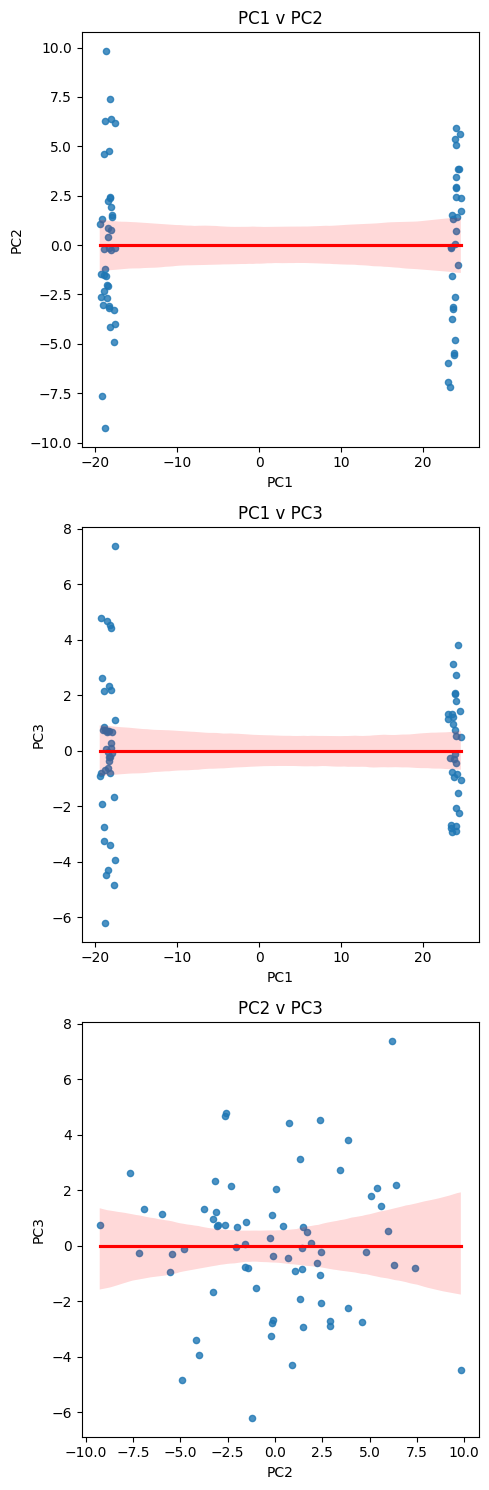

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

X_train_pca_df = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2', 'PC3'])
X_train_pca_df['Y'] = y_train_no_outliers.copy()

fig, axes = plt.subplots(3, 1, figsize=(5,15))

sns.regplot(x='PC1', y='PC2', data=X_train_pca_df,scatter_kws={'s': 20}, line_kws={'color':'red'}, ax = axes[0])
sns.regplot(x='PC1', y='PC3', data=X_train_pca_df,scatter_kws={'s': 20}, line_kws={'color':'red'}, ax = axes[1])
sns.regplot(x='PC2', y='PC3', data=X_train_pca_df,scatter_kws={'s': 20}, line_kws={'color':'red'}, ax = axes[2])

axes[0].set_title('PC1 v PC2')
axes[1].set_title('PC1 v PC3')
axes[2].set_title('PC2 v PC3')

plt.tight_layout()

plt.show()

De los datos del PCA, podemos ver que el primer componente es el que explica la mayor varianza, por sobre el 90%. También de la gráfica se puede observar que la línea de regresión se encuentra cercano a 0 en todos los gráficso, lo que indica que es muy probable que no hay una correlación entre los componentes del PCA, lo cual es esperable. Mientras que PC1, al ser el que explica la mayor varianza, es también el único componente capaz de detectar ciertos patrones en lso datos, como lo es la separación de los elementos que se encuentran a la izquierda y la derecha.

## 4. Modelamiento

Se implementarán para su comparación en su rendimiento 4 modelos de regresión distintos, estos son

1. Support Vector Regression, con un kernel radial (SVR)
2. Random Forest Regressor (RF)
3. Linear Regression (LR)
4. Polynomial Regression (PR)

Los métodos 1, 2 y 4 fueron escogidos al consultar en internet sobre modelos que pudiesen trabajar con regresión de datos no lineales, mientras que el modelo 3, inicialmente se probó para tener una base comparativa con los otros modelos.


In [11]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

#We have to apply the same transformations we applied to the training data
#These are: zscore, and pca transform.
X_test_pca = pca.transform(X_zscore_test)

svr = SVR(kernel='rbf')
rf = RandomForestRegressor()
lin = LinearRegression()
degree = 2
poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())


Para tener una idea del funcionamiento de los modelos antes de probar con los sets de validación, se realiza un grid search en conjunto a un 10-fold cross validation, probando distintos hiperparámetros para obtener el modelo con el mejor rendimiento en cada caso. El entrenamiento se hace en conjunto, ya que tomando los hiperparámetros de nuestra grilla, entrenaremos un modelo y no quedaremos con, en el que en este caso tenga mejor Mean Squared Error.

In [12]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import explained_variance_score

models = {
    'SVR': (svr, {'C': [1e-2, 1e-1, 1, 1e1, 1e2], 'gamma': ['scale', 'auto']}),
    'Random Forest': (rf, {'n_estimators': [10, 25, 50, 150, 200, 250, 300]}),
    'Linear': (lin, {}), #No parameters
    'Polynomial' :(poly, {'polynomialfeatures__degree':[1,2,3]})
}

results = {'Model':[], 'Metric':[], 'Score':[]}
best_results = {'Model':[], 'Metric':[], 'Score':[]}
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
best_models = {}

scoring_metrics = ['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'explained_variance']
for model_name, (model, param_grid) in models.items():
  grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring=scoring_metrics,
                             refit = 'neg_mean_squared_error', return_train_score = True)
  grid_search.fit(X_train_pca, y_train_no_outliers)
  best_params = grid_search.best_params_
  print(best_params)
  if model_name == 'Support Vector Regression': #This works differently for some reason.
    best_model = SVR(**best_params)
  else:
    best_model = model.set_params(**best_params)

  best_model.fit(X_train_pca, y_train_no_outliers)
  best_models[model_name] = best_model

  for metric in scoring_metrics:
      scores = grid_search.cv_results_[f'mean_test_{metric}']
      best_scores = grid_search.cv_results_[f'mean_test_{metric}'][grid_search.best_index_]
      for score in scores: #All scores.
        results['Model'].append(model_name)
        results['Metric'].append(metric)
        results['Score'].append(score)

      best_results['Model'].append(model_name) #Best scores
      best_results['Metric'].append(metric)
      best_results['Score'].append(best_scores)

{'C': 10.0, 'gamma': 'scale'}
{'n_estimators': 150}
{}
{'polynomialfeatures__degree': 2}


Se puede graficar las métricas de acuerdo a su cambio durante la validación.

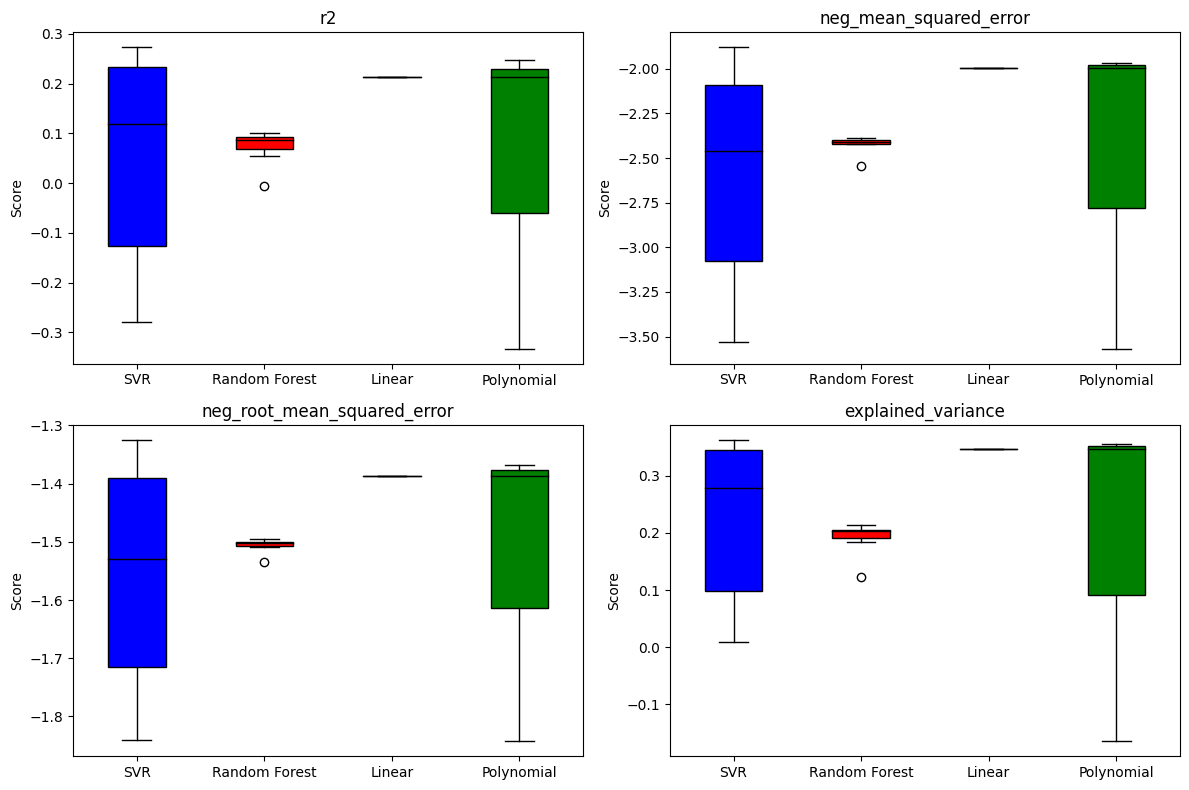

            Model                       Metric     Score
0             SVR                           r2  0.272978
1             SVR       neg_mean_squared_error -1.880708
2             SVR  neg_root_mean_squared_error -1.324849
3             SVR           explained_variance  0.350812
4   Random Forest                           r2  0.101568
5   Random Forest       neg_mean_squared_error -2.389787
6   Random Forest  neg_root_mean_squared_error -1.494415
7   Random Forest           explained_variance  0.214763
8          Linear                           r2  0.212505
9          Linear       neg_mean_squared_error -1.996461
10         Linear  neg_root_mean_squared_error -1.386360
11         Linear           explained_variance  0.347725
12     Polynomial                           r2  0.247547
13     Polynomial       neg_mean_squared_error -1.965899
14     Polynomial  neg_root_mean_squared_error -1.367548
15     Polynomial           explained_variance  0.355623 

SVR , r2 , mean: 0.0569638088

In [13]:
import numpy as np

df_results = pd.DataFrame(results)
# Plot boxplots
plt.figure(figsize=(12, 8))

colors = ['blue', 'red', 'orange', 'green']

for i, metric in enumerate(scoring_metrics):
    plt.subplot(2, 2, i+1)
    plt.title(metric)
    box = plt.boxplot([df_results[(df_results['Model'] == model) & (df_results['Metric'] == metric)]['Score']
                 for model in models.keys()], labels=models.keys(), patch_artist=True)
    plt.ylabel('Score')
    #plt.xticks(rotation='vertical')
    for patch, color in zip(box['boxes'], colors):
      patch.set_facecolor(color)
    for median in box['medians']:
      median.set_color('black')


plt.tight_layout()
plt.show()

print(pd.DataFrame(best_results), "\n")

for i, metric in enumerate(scoring_metrics):
  for model in models.keys():
    val = df_results[(df_results['Model'] == model) & (df_results['Metric'] == metric)]['Score']
    print(model, ",", metric, ", mean:" ,np.mean(val), "sd:", np.std(val))

Finalmente, también se pueden graficar la comparación entre los valores de y reales y los predichos, sirviendo para visualizar el funcionamiento del modelo en datos que no ha visto antes y ver las diferencias con los resultados de entrenamiento.

SVR R2: 0.3411754252119734
SVR MSE: 2.0827309957845737
SVR RMSE: 1.443167002042582
SVR Explained Variance 0.35974057865922726 

Random Forest R2: 0.3160986121908501
Random Forest MSE: 2.1620059010526287
Random Forest RMSE: 1.470376108705738
Random Forest Explained Variance 0.33154344610044617 

Linear R2: 0.34004846369895514
Linear MSE: 2.0862936401728382
Linear RMSE: 1.4444007893146689
Linear Explained Variance 0.37268082204873487 

Polynomial R2: 0.5336287012040786
Polynomial MSE: 1.474331706371295
Polynomial RMSE: 1.2142206168449352
Polynomial Explained Variance 0.5812569196266969 



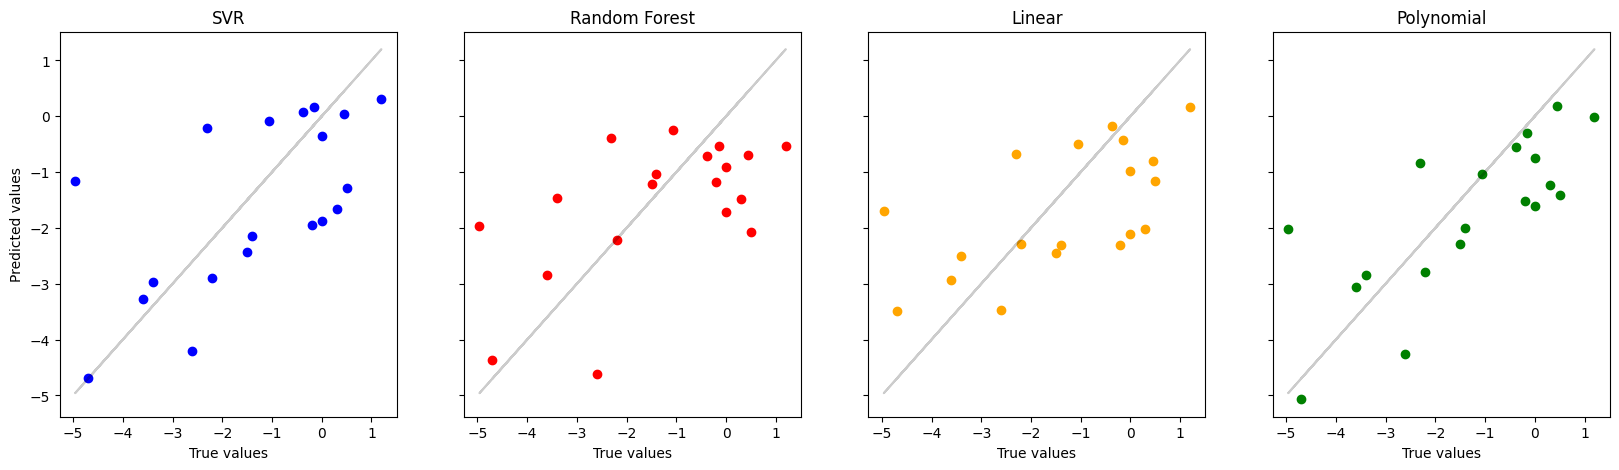

In [14]:
y_preds = []
labels = []
for model_name, best_model in best_models.items():
    y_pred = best_model.predict(X_test_pca)
    labels.append(model_name)
    r2 = r2_score(y_test, y_pred)
    neg_mse = mean_squared_error(y_test, y_pred)
    neg_rmse = mean_squared_error(y_test, y_pred, squared=False)
    e_v = explained_variance_score(y_test, y_pred)
    y_preds.append(y_pred)
    print(model_name, "R2:", r2)
    print(model_name, "MSE:", neg_mse)
    print(model_name, "RMSE:", neg_rmse)
    print(model_name, "Explained Variance", e_v, '\n')

fig, axs = plt.subplots(1, len(y_preds), figsize=(20, 5), sharey=True)

axs[0].set_ylabel("Predicted values")
for i in range(0,len(y_preds)):
  y_ = y_preds[i]
  axs[i].scatter(y_test, y_, color=colors[i], label=labels[i])
  axs[i].set_title(labels[i])
  axs[i].set_xlabel("True values")
  axs[i].plot(y_test, y_test, color = 'black', alpha=0.2)

plt.show()
